In [58]:
import fastf1 as ff1
import fastf1.plotting as ff1plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')


In [59]:
# USE TO GET THE ROUUND NUMBERS
schedule = ff1.get_event_schedule(2024)
# print(schedule)
# print(schedule.columns)
print(schedule.loc[:,['RoundNumber', 'Country', 'Location']])


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule


    RoundNumber               Country           Location
0            10                 Spain          Barcelona
1            11               Austria          Spielberg
2            12         Great Britain        Silverstone
3            13               Hungary           Budapest
4            14               Belgium  Spa-Francorchamps
5            15           Netherlands          Zandvoort
6            16                 Italy              Monza
7            17            Azerbaijan               Baku
8            18             Singapore         Marina Bay
9            19         United States             Austin
10           20                Mexico        Mexico City
11           21                Brazil          São Paulo
12           22         United States          Las Vegas
13           23                 Qatar             Lusail
14           24  United Arab Emirates         Yas Island


In [60]:
# SESSION CONFIGURATION

YEAR = 2024
ROUND = 12
SESSION = 'R'
try:
    session = ff1.get_session(YEAR,ROUND,SESSION)
    session.load()
    event_name = session.event['EventName']
    session_name = session.name
    print(f"\n Event: {event_name} \n Session: {session_name} \n Date: {session.date}")
    if SESSION == 'R':
        results = session.results
        top_3_drivers = results.head(3)['Abbreviation'].tolist()
        print(f"Podium: {top_3_drivers}")
    else:
        laps = session.laps
        fastest_laps = laps.groupby('Driver')['LapTime'].min().sort_values()
        top_3_drivers = fastest_laps.head(3).index.tolist()
        print(f"Top 3 fastest drivers: {top_3_drivers}")
except Exception as e:
    print(f"Error loading session: {e}")
    
    

core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Parsing car data...
_api        WARNING 	Driver 21: Car data is incomplete!
_api        WARNING 	Driver  3: Car data is incomplete!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Par


 Event: British Grand Prix 
 Session: Race 
 Date: 2024-07-07 14:00:00
Podium: ['HAM', 'VER', 'NOR']


In [61]:
# TELEMETRY

telemetry_data = {}
fastest_laps_data = {}
for i,driver in enumerate(top_3_drivers):
    try:
        print(f"Processing {driver}...", end="")
        driver_laps = session.laps.pick_driver(driver)
        fastest_lap = driver_laps.pick_fastest()
        if fastest_lap.empty:
            print("No data")
            continue
        telemetry = fastest_lap.get_telemetry()
        if len(telemetry) < 100:
            print(f"Insufficient data ({len(telemetry)} points)")
            continue
        telemetry_data[driver] = telemetry
        fastest_laps_data[driver] = fastest_lap
        lap_time = fastest_lap['LapTime']
        data_points = len(telemetry)
        print(f"{lap_time} ({data_points} data points)")
    except Exception as e:
        print(f"Error: {str(e)[:50]}...")
print(f"Successfully processed {len(telemetry_data)} drivers")

if len(telemetry_data) < 2:
    print("WARNING: Need at least 2 drivers")

Processing HAM...0 days 00:01:29.438000 (685 data points)
Processing VER...0 days 00:01:28.952000 (682 data points)
Processing NOR...0 days 00:01:29.262000 (688 data points)
Successfully processed 3 drivers


Creating track dominance visualisation...
    Track coordinates: 685 points


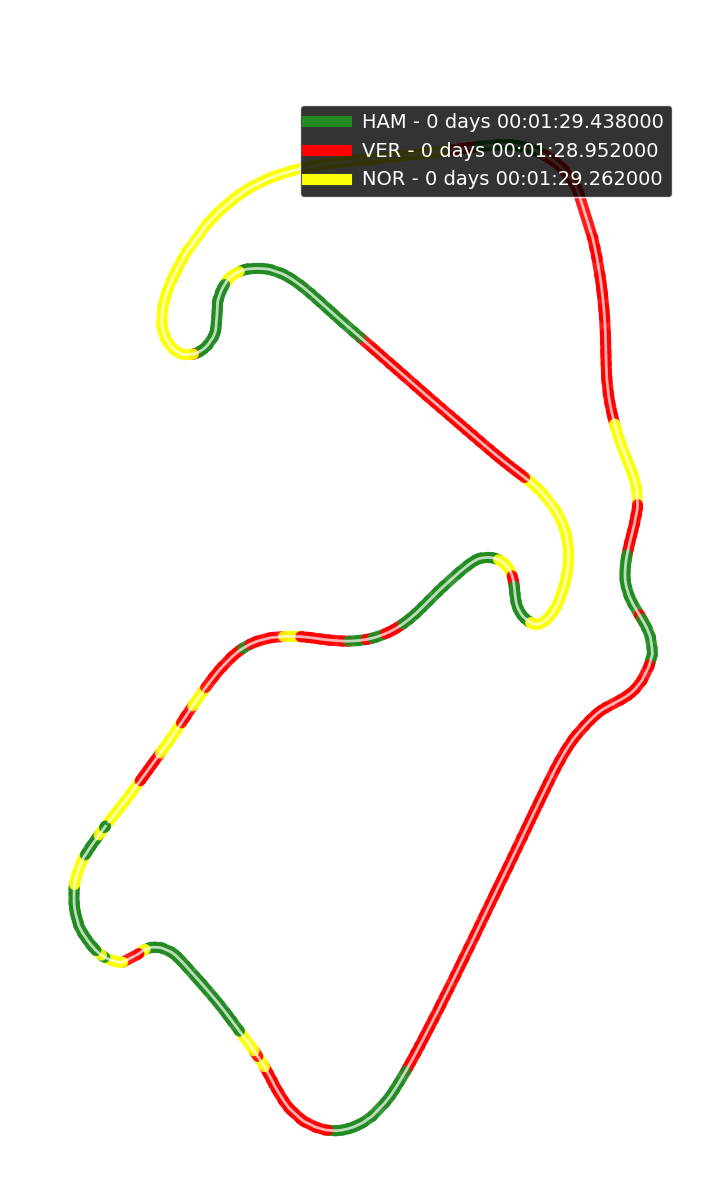

Track Dominance Visualisation Complete


In [62]:
# VISUALISATION

def create_track_dominance_plot():
    if len(telemetry_data) < 2:
        print("Need at least 2 drivers for track dominance")
        return
    print("Creating track dominance visualisation...")
    fig,ax = plt.subplots(figsize=(16,12))
    driver_colors = {
        top_3_drivers[0]: '#228B22',
        top_3_drivers[1]: '#FF0000',
        top_3_drivers[2]: "#FBFF03"
    }
    reference_driver = list(telemetry_data.keys())[0]
    ref_telemetry = telemetry_data[reference_driver]
    x = ref_telemetry['X'].values
    y = ref_telemetry['Y'].values
    print(f"    Track coordinates: {len(x)} points")

    speeds_by_driver = {}
    for driver in telemetry_data.keys():
        tel = telemetry_data[driver]
        if len(tel) > 10:
            f = interpolate.interp1d(
                np.linspace(0,1,len(tel)),
                tel['Speed'].values,
                kind='linear',
                bounds_error=False,
                fill_value='extrapolate'
            )
            speeds_by_driver[driver] = f(np.linspace(0,1,len(x)))
    
    fastest_driver_segments = []
    for i in range(len(x)):
        max_speed = 0
        fastest_driver = list(speeds_by_driver.keys())[0]
        for driver,speeds in speeds_by_driver.items():
            if i < len(speeds) and speeds[i] > max_speed:
                max_speed = speeds[i]
                fastest_driver = driver
        fastest_driver_segments.append(fastest_driver)
    
    for i in range(len(x)-1):
        if i < len(fastest_driver_segments):
            driver = fastest_driver_segments[i]
            color = driver_colors.get(driver,'#CCCCCC')
            ax.plot([x[i],x[i+1]],[y[i],y[i+1]],
                    color=color,linewidth=8,alpha=0.9,solid_capstyle='round')
    
    ax.plot(x,y,color='white',linewidth=2,alpha=0.7)
    ax.set_facecolor('black')
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(f'{YEAR} {event_name} | {session_name}\n'
              f'Track Dominance Analysis - Top 3 Drivers',
              color='white',fontsize=22,pad=20,weight='bold')
    
    legend_elements = []
    for driver in top_3_drivers:
        if driver in telemetry_data and driver in fastest_laps_data:
            lap_time = fastest_laps_data[driver]['LapTime']
            legend_elements.append(
                plt.Line2D([0],[0],color=driver_colors[driver],
                           lw=8,label=f'{driver} - {lap_time}')
            )
    ax.legend(handles=legend_elements,loc='upper right',facecolor='black',
              edgecolor='white',labelcolor='white',fontsize=14,framealpha=0.8)
    plt.tight_layout()
    plt.show()
    print("Track Dominance Visualisation Complete")

create_track_dominance_plot()



Creating speed analysis charts...
Generating Speed Comparison...
Calculating Time Differences...


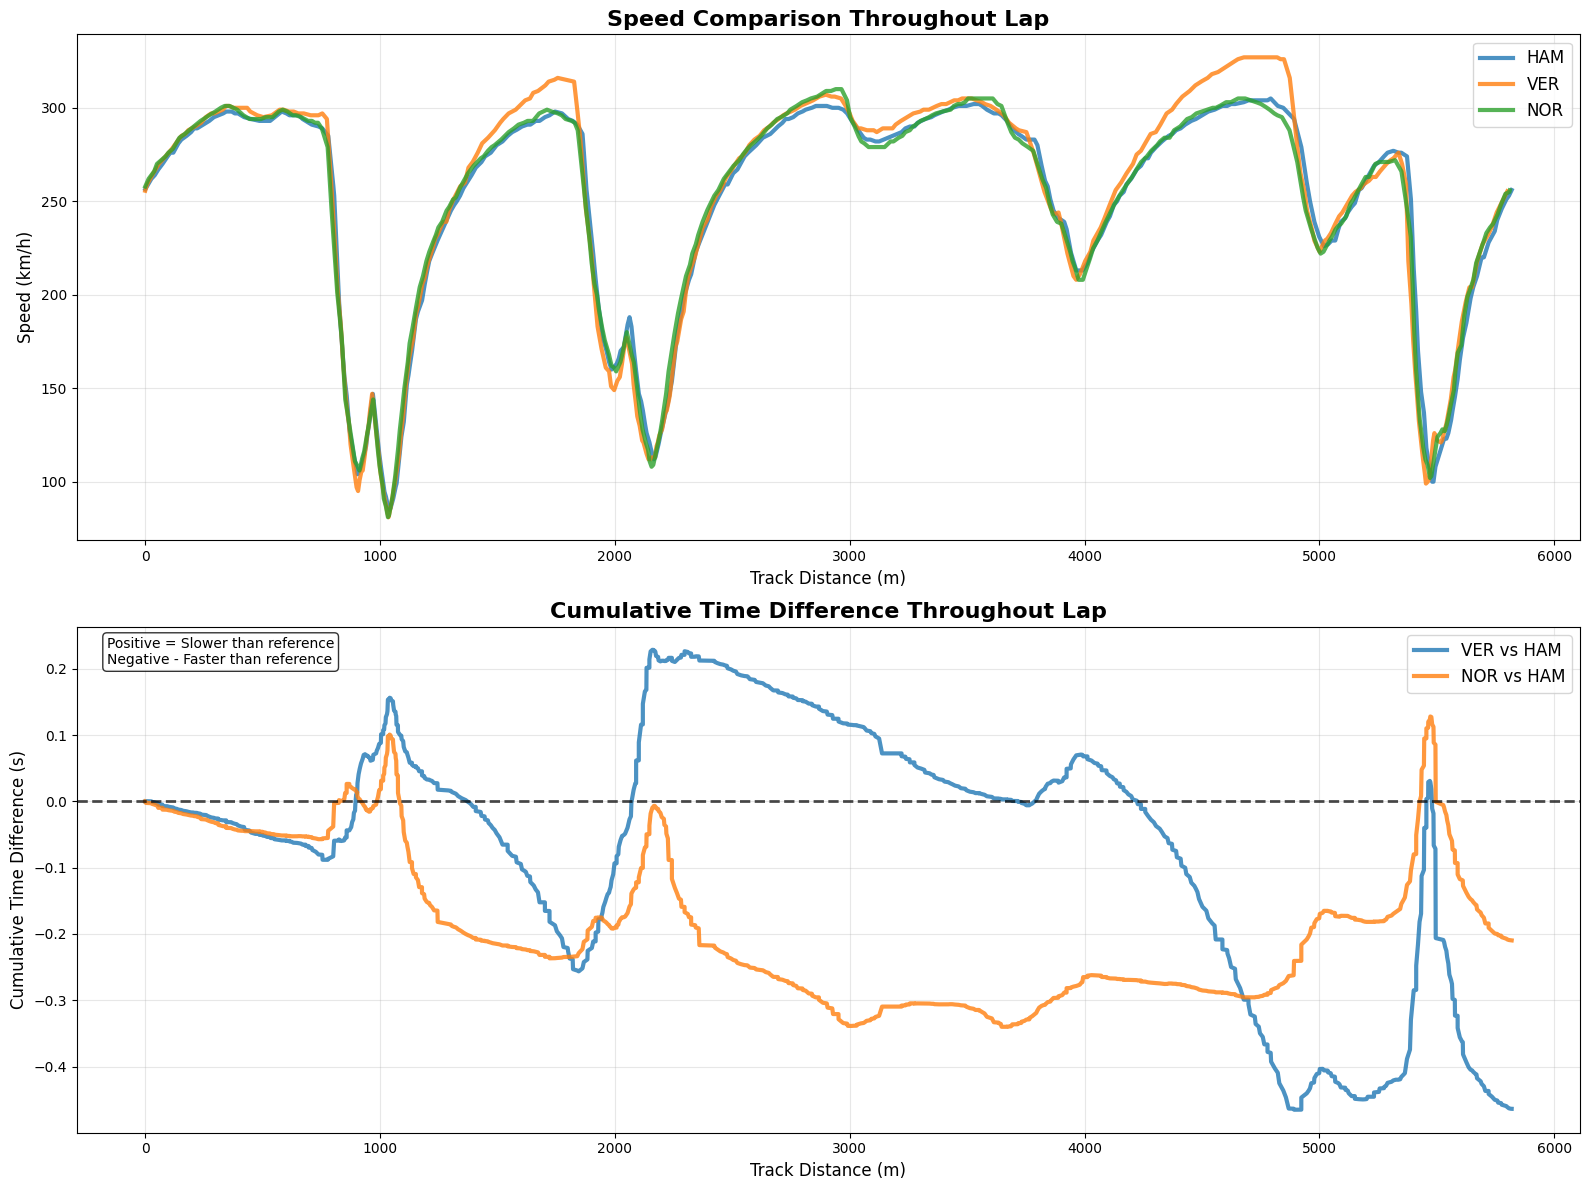

Speed analysis complete


In [63]:
# SPEED ANALYSIS

def create_speed_comparison():
    if len(telemetry_data) < 2:
        print("Need at least 2 drivers for speed comparison")
        return
        
    print("Creating speed analysis charts...")

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,12))
    print("Generating Speed Comparison...")
    for driver in telemetry_data.keys():
        tel = telemetry_data[driver]
        ax1.plot(tel['Distance'],tel['Speed'],label=f'{driver}',linewidth=3,alpha=0.8)
    ax1.set_xlabel('Track Distance (m)',fontsize=12)
    ax1.set_ylabel('Speed (km/h)',fontsize=12)
    ax1.set_title('Speed Comparison Throughout Lap',fontsize=16,weight='bold')
    ax1.legend(fontsize=12)
    ax1.grid(True,alpha=0.3)

    print("Calculating Time Differences...")
    reference_driver = list(telemetry_data.keys())[0]
    ref_tel = telemetry_data[reference_driver]
    common_distance = ref_tel['Distance'].values
    interpolated_speeds = {}
    try:
        for driver in telemetry_data.keys():
            tel = telemetry_data[driver]
            if len(tel['Distance']) > 10:
                f_speed = interpolate.interp1d(
                    tel['Distance'],tel['Speed'],
                    kind='linear',bounds_error=False,
                    fill_value='extrapolate'
                )
                interpolated_speeds[driver] = f_speed(common_distance)
        if reference_driver in interpolated_speeds:
            ref_speed = interpolated_speeds[reference_driver]
            for driver in interpolated_speeds.keys():
                if driver != reference_driver:
                    driver_speed = interpolated_speeds[driver]
                    distance_segments = np.diff(common_distance)
                    distance_segments = np.append(distance_segments,distance_segments[-1])
                    ref_speed_safe = np.maximum(ref_speed,1.0)
                    driver_speed_safe = np.maximum(driver_speed,1.0)
                    ref_time_segments = distance_segments/(ref_speed_safe/3.6)
                    driver_time_segments = distance_segments/(driver_speed_safe/3.6)
                    time_diff = np.cumsum(driver_time_segments-ref_time_segments)
                    ax2.plot(common_distance,time_diff,label=f'{driver} vs {reference_driver}', linewidth=3,alpha=0.8)
        ax2.set_xlabel('Track Distance (m)',fontsize=12)
        ax2.set_ylabel('Cumulative Time Difference (s)',fontsize=12)
        ax2.set_title('Cumulative Time Difference Throughout Lap',fontsize=16,weight='bold')
        ax2.legend(fontsize=12)
        ax2.grid(True,alpha=0.3)
        ax2.axhline(y=0,color='black',linestyle='--',alpha=0.7,linewidth=2)
        ax2.text(0.02,0.98,'Positive = Slower than reference\nNegative - Faster than reference',
                 transform=ax2.transAxes,fontsize=10,verticalalignment='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8))
    except Exception as e:
        print(f"Error in time calculation: {e}")
        ax2.text(0.5,0.5,'Error calculating time differences\nCheck data uality', transform=ax2.transAxes,ha='center',va='center',fontsize=14)
    
    plt.tight_layout()
    plt.show()
    print("Speed analysis complete")

create_speed_comparison()

In [64]:
#SECTOR PERFORMANCE

def performance_analysis():
    if len(telemetry_data) < 2:
        print("Need at least 2 drivers for speed comparison")
        return
        
    print("Performing Sector Analysis...")
    sector_data = {}
    for driver in top_3_drivers:
        if driver in fastest_laps_data:
            lap = fastest_laps_data[driver]
            sector_data[driver] = {
                'Sector 1': lap['Sector1Time'],
                'Sector 2': lap['Sector2Time'],
                'Sector 3': lap['Sector3Time'],
                'Total Lap': lap['LapTime']
            }
    if not sector_data:
        print("No sector data available")
        return None
    
    df_sectors = pd.DataFrame(sector_data).T
    print("Sector Performance Analysis")
    print("=" * 50)
    print(f"Event: {event_name} ({YEAR})")
    print(f"Session: {session_name}")
    print()
    print("Sector Times:")
    print(df_sectors.to_string())
    print()
    print("Fastest Per Sector:")
    sector_winners = {}
    for sector in ['Sector 1','Sector 2','Sector 3']:
        if sector in df_sectors.columns:
            fastest_driver = df_sectors[sector].idxmin()
            fastest_time = df_sectors[sector].min()
            sector_winners[sector] = fastest_driver
            print(f"{sector}: {fastest_driver} - {fastest_time}")
    
    if 'Total Lap' in df_sectors.columns:
        overall_fastest = df_sectors['Total Lap'].idxmin()
        overall_time = df_sectors['Total Lap'].min()
        print(f"Overall: {overall_fastest} - {overall_time}")
    print()

    print("Performance Summary:")
    sector_wins = {}
    for driver in top_3_drivers:
        if driver in sector_data:
            wins = sum(1 for winner in sector_winners.values() if winner == driver)
            sector_wins[driver] = wins
            print(f"{driver}: {wins} sector win(s)")
    
    if sector_wins:
        most_dominant = max(sector_wins,key=sector_wins.get)
        max_wins = sector_wins[most_dominant]
        if max_wins > 0:
            print(f"Most Dominant: {most_dominant} ({max_wins}/3 sectors)")
    
    print("Sector Analysis Complete")
    return df_sectors

sector_results = performance_analysis()

Performing Sector Analysis...
Sector Performance Analysis
Event: British Grand Prix (2024)
Session: Race

Sector Times:
                  Sector 1               Sector 2               Sector 3              Total Lap
HAM 0 days 00:00:29.064000 0 days 00:00:36.042000 0 days 00:00:24.332000 0 days 00:01:29.438000
VER 0 days 00:00:28.807000 0 days 00:00:36.166000 0 days 00:00:23.979000 0 days 00:01:28.952000
NOR 0 days 00:00:28.826000 0 days 00:00:35.997000 0 days 00:00:24.439000 0 days 00:01:29.262000

Fastest Per Sector:
Sector 1: VER - 0 days 00:00:28.807000
Sector 2: NOR - 0 days 00:00:35.997000
Sector 3: VER - 0 days 00:00:23.979000
Overall: VER - 0 days 00:01:28.952000

Performance Summary:
HAM: 0 sector win(s)
VER: 2 sector win(s)
NOR: 1 sector win(s)
Most Dominant: VER (2/3 sectors)
Sector Analysis Complete
